# Making Python Faster

<img src="slides/warp1.jpg">


<h2> ... and using legacy code</h2>

- we've already seen `numexpr`, parallelization, etc.

- Python is _slow_ ... it's interpreted on the fly

- no static typing ... even integers are objects (bulky memory!)

- what if we want to write Python, but use it as a *glue* to fast C-code?

<pre>
Premature optimization is the root of all evil 
   -- Donald Knuth
</pre>

<pre>
C is premature optimization
   -- Kanye West
</pre>


## Profiling ##

You already know that Python comes with batteries include, and performance profiling is no exception.

You can keep track of how much time each *function* is taking up using tools from the standard library.

Here's the [documentation of `profile` and `cProfile`](http://docs.python.org/3/library/profile.html), but you probably won't need to use them directly.  A profile is a set of statistics that describes how often and for how long various parts of the program executed. These statistics can be formatted into reports via the pstats module.

In [88]:
import cProfile
import re
cProfile.run('re.compile("foo|bar")') # run a piece of code

         5 function calls in 0.002 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        1    0.000    0.000    0.001    0.001 re.py:222(compile)
        1    0.001    0.001    0.001    0.001 re.py:278(_compile)
        1    0.001    0.001    0.002    0.002 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [ ]:
import cProfile, pstats, io
pr = cProfile.Profile()
pr.enable()

# here's the code you want to profile
def waste_of_time(n=1000):
    [x for x in range(n)]
[waste_of_time(y) for y in range(10000)]
## end of code you want to profile

pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

## There's a magic for that!

### `%timeit` to learn how long it takes a chunk of code to run

### `%prun` for function-by-function breakdown of code in your namespace

### `%run -p` for function-by-function breakdown of running a whole file

In [201]:
cd demos/profile

/Users/jbloom/Classes/python-seminar/Lectures/11_Cython/demos/profile


In [202]:
!cat sometask.py

import numpy as np

def expensive_square(x):
    x = x.copy()
    for i in range(x.size):
        x[i] = x[i] ** 2

    return x

def cheap_square(x):
    return x**2

square = expensive_square
#square = cheap_square

def execute():
    print("Squaring some numbers...")
    x = np.arange((500000))
    y = square(x)

#    np.testing.assert_equal(x**2, y)

if __name__ == "__main__":
    execute()


In [203]:
import sometask

In [204]:
%prun sometask.execute()

Squaring some numbers...
 

In [205]:
%run -p sometask.py

Squaring some numbers...
 

With the `-D` flag, you can dump the profile to binary file that external tools can use.


You  can also produce this .profile without Jupyter using:

```bash
    python -m cProfile -o sometask.profile sometask.py
```

In [207]:
%run -p -D sometask.profile sometask.py

Squaring some numbers...
 
*** Profile stats marshalled to file 'sometask.profile'. 


In [ ]:
#!pip install snakeviz

In [209]:
!snakeviz sometask.profile

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fjbloom%2FClasses%2Fpython-seminar%2FLectures%2F11_Cython%2Fdemos%2Fprofile%2Fsometask.profile
^C
Bye!



In [210]:
%load_ext snakeviz

In [211]:
%%snakeviz
sometask.execute()

Squaring some numbers...
 
*** Profile stats marshalled to file '/var/folders/dc/1sk9z_cx15s7g6895fqjlp7h0000gn/T/tmptume44wc'. 


## Profiling line-by-line

    %lprun
    
This magic is not built into Jupyter, it is provided by the [line_profiler package by Robert Kern](http://pythonhosted.org/line_profiler/).

In [ ]:
!conda install line_profiler -y

In [215]:
%load_ext line_profiler

Run the code, but only run the line profiler on the function `square()`

In [216]:
import sometask

In [217]:
%lprun -f sometask.square sometask.execute()

Squaring some numbers...


## Profiling memory usage (line-by-line)

    %mprun
    
        
This magic is not built into Jupyter, it is provided by the [memory_profiler package by Fabian Pedregosa](https://pypi.python.org/pypi/memory_profiler).

In [218]:
!pip install --user  -U memory_profiler

Requirement already up-to-date: memory_profiler in /Users/jbloom/anaconda/envs/seminar/lib/python3.5/site-packages


In [219]:
%load_ext memory_profiler

In [220]:
%mprun?

In [221]:
import sometask

In [222]:
%mprun -f sometask.square sometask.execute()

Squaring some numbers...



# Other tools for profiling:

[gprof](http://en.wikipedia.org/wiki/Gprof) -- command line profiling tool for C code. [GNU Gprof documentation](https://sourceware.org/binutils/docs/gprof/) is pretty good.

[valgrind](http://valgrind.org/docs/manual/cl-manual.html) -- very complex suite for analyzing callgrind and kcachegrind. "*Valgrind is an instrumentation framework for building dynamic analysis tools. There are Valgrind tools that can automatically detect many memory management and threading bugs, and profile your programs in detail.*"

[Timing and Profiling in IPython](http://pynash.org/2013/03/06/timing-and-profiling/) : Blogpost at the PyNashville

Calculate the variance

$$\sigma^2 = \frac {\sum_{i=1}^N (x_i - \sum_{j=1}^N x_j/N)^2}{N - 1}. $$

problem here is that you must first pass over all the data (to get the mean) then pass over the data again.  There's a bunch of Pythonic ways to do this. Here's a few...

In [243]:
#%%writefile var.py
def variance(data):
    sample_mean = 0.0
    
    # 1st loop
    for x in data:
        sample_mean += float(x)
    
    sample_mean /= len(data)
    
    # second loop
    sum_of_squared_errors = 0.0
    for x in data:
        sum_of_squared_errors += (float(x) - sample_mean) ** 2
    
    return sum_of_squared_errors / (float(len(data)) - 1.0)
    
def variance0(data):
   sample_mean = sum(data) / len(data) # loop 1
   sum_of_squared_errors = sum((i - sample_mean) ** 2 for i in data) # loop 2
   return sum_of_squared_errors / (len(data) - 1)

import functools
def variance1(data):
    mean = float(functools.reduce(lambda x,y : x+y, data)) / len(data)
    return functools.reduce(lambda x,y: x+y, map(lambda xi: (xi-mean)**2, data))/ (len(data) - 1)

def execute():
    variance(range(100000))
    
def execute1():
    variance1(range(100000))

Overwriting var.py


In [92]:
%timeit variance(range(100000))

10 loops, best of 3: 57.5 ms per loop


In [93]:
%timeit variance0(range(100000))

10 loops, best of 3: 25.7 ms per loop


In [94]:
%timeit variance1(range(100000))

10 loops, best of 3: 64.8 ms per loop


We'd like to do this with just one pass over the data. Have a look at Welford's Method (1962):

In [95]:
def online_variance(data):
    mean,M2= 0.,0.
    for n,d in enumerate(data):
        delta = d - mean
        mean += delta/(n + 1)
        M2 += delta*(d - mean)  
    return M2/n

In [96]:
%timeit online_variance(range(100000))

10 loops, best of 3: 38.1 ms per loop


In [244]:
import importlib
importlib.reload(var)

<module 'var' from '/Users/jbloom/Classes/python-seminar/Lectures/11_Cython/demos/profile/var.py'>

In [246]:
%lprun -f var.variance1 var.execute1()

## Numba  ##

LLVM compiler for python (brought to you by Continuum). In short: Python code can be converted to highly efficient compiled code in real-time. 

Should be on everyone's conda installation already. But you might want to update (it's been changed recently):

   `conda update numba`


In [ ]:
!conda install numba -y

In [97]:
import numba
numba.__version__

'0.29.0'

How compilers usually work:

<img src="http://www.aosabook.org/images/llvm/SimpleCompiler.png">

How LLVM works:

<img src="http://www.aosabook.org/images/llvm/RetargetableCompiler.png">

Credit: http://www.aosabook.org/en/llvm.html

(Via http://nbviewer.ipython.org/urls/raw.github.com/aterrel/HPCPythonSC2012/master/02_Speeding_Python.ipynb)

In [110]:
from numba import int32, float32
print(int32[:])           # 1D int32 array
print(float32[:,:])       # 2D float32 array
print(int32[:,:,:,:])     # 4D int32 array

array(int32, 1d, A)
array(float32, 2d, A)
array(int32, 4d, A)


Function types are created from "calling" a Numba type object.

In [111]:
from numba import void, int32, float32, complex64
print(complex64(int32, float32, complex64))
print(float32())                             # no arguments
print(void(float32))                         # return nothing
print(void(float32[:], int32[:]))

(int32, float32, complex64) -> complex64
() -> float32
(float32,) -> none
(array(float32, 1d, A), array(int32, 1d, A)) -> none


The `@jit` decorator returns a compiled version of the function using the input types and the output types of the function. You can specify the type using out_type(in_type, ...) syntax. Array inputs can be specified using `[:,:]` appended to the type.

In [112]:
from numba import jit, int32, float32, complex64

@jit(complex64(int32, float32, complex64))
def bar(a, b, c):
   return a + b  * c

@jit(complex64(int32, float32, complex64))
def foo(a, b, c):
   return a + b  * c

print(foo)
print(foo(1, 2.0, 3.0j))

CPUDispatcher(<function foo at 0x1096d37b8>)
(1+6j)


In [130]:
foo("a","b",3)

TypeError: No matching definition for argument type(s) str, str, int64

The `@autojit` decorator does not require you to specify any types. It watches for what types you call the function with and infers the type of the return. If there is a previously compiled version of the code available it uses it, if not it generates machine code for the function and then executes that code.

In [131]:
@autojit
def f2(x,y):
    return x + y

print(f2("a","b"))
print(f2(1,2))

ab
3


In [132]:
from numba import double
from numba import jit

@autojit
def n_variance(data):
    sample_mean = 0.0
    
    # 1st loop
    for x in data:
        sample_mean =  sample_mean + float(x)
    
    sample_mean = sample_mean / len(data)
    
    # second loop
    sum_of_squared_errors = 0.0
    for x in data:
        sum_of_squared_errors += (float(x) - sample_mean) ** 2
    
    ret =  sum_of_squared_errors / (float(len(data)) - 1.0)
    return ret

In [134]:
%timeit n_variance(list(range(100000)))

100 loops, best of 3: 4.79 ms per loop


In [135]:
n_ovariance = autojit(online_variance)

In [137]:
%timeit n_ovariance(list(range(100000)))

100 loops, best of 3: 5.17 ms per loop


List comprehension and other fancy Python tricks are not supported yet in numba

In [142]:
n_variance0 = autojit(variance0)
n_variance0(list(range(1000)))

AttributeError: Failed at object (analyzing bytecode)
'DataFlowAnalysis' object has no attribute 'op_STORE_DEREF'

In [ ]:
import numpy

def filter2d(image, filt):
    M, N = image.shape
    Mf, Nf = filt.shape
    Mf2 = Mf // 2
    Nf2 = Nf // 2
    result = numpy.zeros_like(image)
    for i in range(Mf2, M - Mf2):
        for j in range(Nf2, N - Nf2):
            num = 0.0
            for ii in range(Mf):
                for jj in range(Nf):
                    num += (filt[Mf-1-ii, Nf-1-jj] * image[i-Mf2+ii, j-Nf2+jj])
            result[i, j] = num
    return result


That kind of quadruply-nested for-loop is going to be quite slow.
Using Numba we can compile this code to LLVM which then gets
compiled to machine code:

In [144]:
from numba import double, jit

numbafilter_2d = jit(double[:,:](double[:,:], double[:,:]))(filter2d)

# Now fastfilter_2d runs at speeds as if you had first translated
# it to C, compiled the code and wrapped it with Python
image = numpy.random.random((100, 100))
filt = numpy.random.random((10, 10))
res = numbafilter_2d(image, filt)

In [145]:
%timeit numbafilter_2d(image, filt)

1000 loops, best of 3: 1.69 ms per loop


In [146]:
%timeit filter2d(image, filt)

1 loop, best of 3: 598 ms per loop


In [147]:
%matplotlib inline
import matplotlib.pyplot as plt

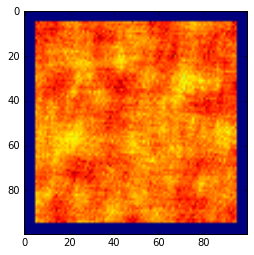

In [150]:
plt.imshow(res)

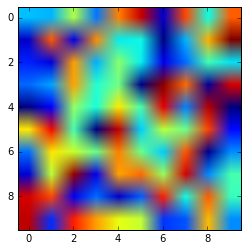

In [148]:
plt.imshow(filt)

<img src="http://pypy.org/image/pypy-logo.png">

Python interpreter and C/JIT compiler. See http://pypy.org/

*“If you want your code to run faster, you should probably just use PyPy.”*
   — Guido van Rossum (creator of Python)


## Ctypes ##

ctypes is a foreign function library for Python. It provides C compatible data types, and allows calling functions in DLLs or shared libraries. It can be used to wrap these libraries in pure Python.

https://docs.python.org/3/library/ctypes.html

In [151]:
from ctypes import *

In [152]:
p = create_string_buffer(b"Hello", 10)  # create a 10 byte buffer

In [153]:
p

In [154]:
p.value

b'Hello'

In [155]:
print(sizeof(p)) ; repr(p.raw)

10


"b'Hello\\x00\\x00\\x00\\x00\\x00'"

In [156]:
repr(p.raw)

"b'Hello\\x00\\x00\\x00\\x00\\x00'"

In [157]:
p.value = b"Bye."

In [158]:
print(sizeof(p)) ; repr(p.raw)

10


"b'Bye.\\x00\\x00\\x00\\x00\\x00\\x00'"

<table border="1" class="docutils">
<colgroup>
<col width="24%" />
<col width="46%" />
<col width="30%" />
</colgroup>
<thead valign="bottom">
<tr><th class="head">ctypes type</th>
<th class="head">C type</th>
<th class="head">Python type</th>
</tr>
</thead>
<tbody valign="top">
<tr><td><a class="reference internal" href="#ctypes.c_bool" title="ctypes.c_bool"><tt class="xref py py-class docutils literal"><span class="pre">c_bool</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">_Bool</span></tt></td>
<td>bool (1)</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_char" title="ctypes.c_char"><tt class="xref py py-class docutils literal"><span class="pre">c_char</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">char</span></tt></td>
<td>1-character string</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_wchar" title="ctypes.c_wchar"><tt class="xref py py-class docutils literal"><span class="pre">c_wchar</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">wchar_t</span></tt></td>
<td>1-character unicode string</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_byte" title="ctypes.c_byte"><tt class="xref py py-class docutils literal"><span class="pre">c_byte</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">char</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_ubyte" title="ctypes.c_ubyte"><tt class="xref py py-class docutils literal"><span class="pre">c_ubyte</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">char</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_short" title="ctypes.c_short"><tt class="xref py py-class docutils literal"><span class="pre">c_short</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">short</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_ushort" title="ctypes.c_ushort"><tt class="xref py py-class docutils literal"><span class="pre">c_ushort</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">short</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_int" title="ctypes.c_int"><tt class="xref py py-class docutils literal"><span class="pre">c_int</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">int</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_uint" title="ctypes.c_uint"><tt class="xref py py-class docutils literal"><span class="pre">c_uint</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">int</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_long" title="ctypes.c_long"><tt class="xref py py-class docutils literal"><span class="pre">c_long</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">long</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_ulong" title="ctypes.c_ulong"><tt class="xref py py-class docutils literal"><span class="pre">c_ulong</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">long</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_longlong" title="ctypes.c_longlong"><tt class="xref py py-class docutils literal"><span class="pre">c_longlong</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">__int64</span></tt> or <tt class="xref c c-type docutils literal"><span class="pre">long</span> <span class="pre">long</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_ulonglong" title="ctypes.c_ulonglong"><tt class="xref py py-class docutils literal"><span class="pre">c_ulonglong</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">__int64</span></tt> or
<tt class="xref c c-type docutils literal"><span class="pre">unsigned</span> <span class="pre">long</span> <span class="pre">long</span></tt></td>
<td>int/long</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_float" title="ctypes.c_float"><tt class="xref py py-class docutils literal"><span class="pre">c_float</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">float</span></tt></td>
<td>float</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_double" title="ctypes.c_double"><tt class="xref py py-class docutils literal"><span class="pre">c_double</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">double</span></tt></td>
<td>float</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_longdouble" title="ctypes.c_longdouble"><tt class="xref py py-class docutils literal"><span class="pre">c_longdouble</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">long</span> <span class="pre">double</span></tt></td>
<td>float</td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_char_p" title="ctypes.c_char_p"><tt class="xref py py-class docutils literal"><span class="pre">c_char_p</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">char</span> <span class="pre">*</span></tt> (NUL terminated)</td>
<td>string or <tt class="xref docutils literal"><span class="pre">None</span></tt></td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_wchar_p" title="ctypes.c_wchar_p"><tt class="xref py py-class docutils literal"><span class="pre">c_wchar_p</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">wchar_t</span> <span class="pre">*</span></tt> (NUL terminated)</td>
<td>unicode or <tt class="xref docutils literal"><span class="pre">None</span></tt></td>
</tr>
<tr><td><a class="reference internal" href="#ctypes.c_void_p" title="ctypes.c_void_p"><tt class="xref py py-class docutils literal"><span class="pre">c_void_p</span></tt></a></td>
<td><tt class="xref c c-type docutils literal"><span class="pre">void</span> <span class="pre">*</span></tt></td>
<td>int/long or <tt class="xref docutils literal"><span class="pre">None</span></tt></td>
</tr>
</tbody>
</table>

In [159]:
x = c_int(100)

In [160]:
print(x)

c_int(100)


In [161]:
type(x.value)

int

In [162]:
sizeof(x)

4

In [163]:
y = 100

In [164]:
import sys
sys.getsizeof(y)

28

In [165]:
sys.getsizeof(x)

136

In [166]:
id(y)

4297151696

In [167]:
id(x)

4461132656

In [168]:
id(100)

4297151696

In [169]:
x = 300
id(x)

4459336240

In [170]:
1 is 1

True

In [171]:
"dog" is "dog"

True

In [172]:
"dog" == "dog"

True

In [173]:
-5 is -5

True

In [174]:
x = 10000
y = 10000
print(x is y)

False


In [175]:
print(id(x), id(y))

4460852016 4460851952


In [176]:
x = y
print(id(x), id(y))

4460851952 4460851952


In [177]:
x = "dog!"
y = "dog!"

In [178]:
id(100)

4297151696

In [179]:
id(100)

4297151696

In [180]:
id(23452)

4460852016

In [181]:
id(23452)

4460851984

In [183]:
x = "dog"
y = "dog"
x is y

True

In [184]:
x = "dog_"
y = "dog_"
x is y

True

In [188]:
%%file test.c
#include <stdio.h>

void myprint(void);

void myprint()
{
    printf("hello world\n");
}

Overwriting test.c


In [189]:
# linux
#!gcc -shared -Wl,-soname,test -o test.so -fPIC test.c

# or... for Mac OS X 
!gcc -shared -Wl,-install_name,testlib.so -o test.so -fPIC test.c

In [190]:
%%file myctest.py
import ctypes
myctest = ctypes.CDLL('./test.so')
myctest.myprint()

Overwriting myctest.py


In [191]:
%%file test1.c
int add(int a, int b);

int add(int a, int b)
{
    return(a+b);
}

Overwriting test1.c


In [192]:
!gcc -shared -Wl,-install_name,test1lib.so -o test1.so -fPIC test1.c

In [193]:
from ctypes import *

# load the shared object
libtest = cdll.LoadLibrary('./test1.so')

# call the function, yes it is as simple as that!
print(libtest.add(100, 20))

120


In [194]:
%timeit libtest.add(10,20)

The slowest run took 34.16 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 542 ns per loop


In [195]:
%timeit sum([10,20])

The slowest run took 6.42 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 345 ns per loop


In [ ]:
sum?

In [196]:
%timeit 10 + 20

10000000 loops, best of 3: 19.7 ns per loop


For a whole lot of timing comparisons, see 
http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/NumbaCython.ipynb

## f2py 

<pre>
...automatically construct an extension module that interfaces to routines in Fortran 77/90/95 code. It has the ability to parse Fortran 77/90/95 code and automatically generate Python signatures for the subroutines it encounters, or you can guide how the subroutine interfaces with Python by constructing an interface-definition-file (or modifying the f2py-produced one).
</pre>

It's part of numpy!

(http://docs.scipy.org/doc/numpy/user/c-info.python-as-glue.html#f2py)

In [197]:
%%file pairwise_fort.f

      subroutine pairwise_fort(X,D,m,n)
          integer :: n,m
          double precision, intent(in) :: X(m,n)
          double precision, intent(out) :: D(m,m) 
          integer :: i,j,k
          double precision :: r 
          do i = 1,m 
              do j = 1,m 
                  r = 0
                  do k = 1,n 
                      r = r + (X(i,k) - X(j,k)) * (X(i,k) - X(j,k)) 
                  end do 
                  D(i,j) = sqrt(r) 
              end do 
          end do 
      end subroutine pairwise_fort

Overwriting pairwise_fort.f


In [198]:
!f2py -c pairwise_fort.f -m pairwise_fort > /dev/null

In [199]:
import numpy as np
X = np.random.random((1000, 3))
from pairwise_fort import pairwise_fort
XF = np.asarray(X, order='F')
%timeit pairwise_fort(XF)

100 loops, best of 3: 9.64 ms per loop
